In [95]:
## 15. 오토인코더 ##
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from functools import partial


## GPU 메모리 관리 ##
#1번 방법
config = tf.ConfigProto()
config.gpu_options.allow_growth = True #메모리 수요에 따라 할당

'''주의할 점은, 이 옵션은 메모리의 증식만 가능하다는 것. 연산이 끝나고 메모리가 필요없는 상황이라고 해서 할당된 메모리를 반납하지 않는다. 

Tensorflow 측에서는 그럴 경우 더 심한 메모리 파편화를 일으킬 수도 있다고 하니 판단은 독자의 몫.'''

'주의할 점은, 이 옵션은 메모리의 증식만 가능하다는 것. 연산이 끝나고 메모리가 필요없는 상황이라고 해서 할당된 메모리를 반납하지 않는다. \n\nTensorflow 측에서는 그럴 경우 더 심한 메모리 파편화를 일으킬 수도 있다고 하니 판단은 독자의 몫.'

# 오토인코더

오토인코더(Autoencoder)는 아래의 그림과 같이 단순히 입력을 출력으로 복사하는 신경망이다. 어떻게 보면 간단한 신경망처럼 보이지만 네트워크에 여러가지 방법으로 제약을 줌으로써 어려운 신경망으로 만든다. 예를들어 아래 그림처럼 hidden layer의 뉴런 수를 input layer(입력층) 보다 작게해서 데이터를 압축(차원을 축소)한다거나, 입력 데이터에 노이즈(noise)를 추가한 후 원본 입력을 복원할 수 있도록 네트워크를 학습시키는 등 다양한 오토인코더가 있다. 이러한 제약들은 오토인코더가 단순히 입력을 바로 출력으로 복사하지 못하도록 방지하며, 데이터를 효율적으로 표현(representation)하는 방법을 학습하도록 제어한다.
![autoencoder](images/autoencoder.png)
오토인코더는 위의 그림에서 볼 수 있듯이 항상 인코더(encoder)와 디코더(decoder), 두 부분으로 구성되어 있다.

<ul>
    <li>인코더(encoder) : 인지 네트워크(recognition network)라고도 하며, 입력을 내부 표현으로 변환한다.</li>
    <li>디코더(decoder) : 생성 네트워크(generative nework)라고도 하며, 내부 표현을 출력으로 변환한다.</li>
</ul>
오토인코더는 위의 그림에서 처럼, 입력과 출력층의 뉴런 수가 동일하다는 것만 제외하면 일반적인 MLP(Multi-Layer Perceptron)과 동일한 구조이다. <b style="background:#AEA">오토인코더는 입력을 재구성</b>하기 때문에 출력을 재구성(reconstruction)이라고도 하며, 손실함수는 입력과 재구성(출력)의 차이를 가지고 계산한다.

위 그림의 <b style="background:#AEA">오토인토더는 히든 레이어의 뉴런(노드, 유닛)이 입력층보다 작으므로 입력이 저차원으로 표현</b>되는데, 이러한 오토인코더를 과소완전 오토인코더(Undercomplete Autoencoder)라고 한다. undercomplete 오토인코더는 저차원을 가지는 히든 레이어에 의해 입력을 그대로 출력으로 복사할 수 없기 때문에, 출력이 입력과 같은 것을 출력하기 위해 학습해야 한다. 이러한 학습을 통해 undercomplete 오토인코더는 <b style="background:#AEA">입력 데이터에서 가장 중요한 특성(feature)을 학습하도록</b> 만든다.

## 과소완전 선형 오토인코더로 PCA 수행하기

오토인코더가 선형 활성화 함수만 사용하고 비용 함수가 평균 제곱 오차(MSE)라면, 이는 결국 주성분 분석(PCA)를 수행하는 것으로 볼 수 있다.

In [96]:
# 3D 데이터셋을 만듦
import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

In [16]:
# 데이터 정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

In [17]:
tf.reset_default_graph()

n_inputs = 3 #3D 입력
n_hidden = 2 #2D 코딩
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden, activation=None) #단순히 PCA를 수행하기 위해 활성화 함수 사용 안함(모든 뉴런이 선형)
outputs = tf.layers.dense(hidden, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs-X)) #재구성오차

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

n_iterations = 1000
codings = hidden #코딩을 만드는 입력층을 출력

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    for iteration in range(n_iterations):
        sess.run(training_op, feed_dict={X: X_train}) #레이블이 없음(비지도 학습)
    codings_val = sess.run(codings, feed_dict={X: X_test})

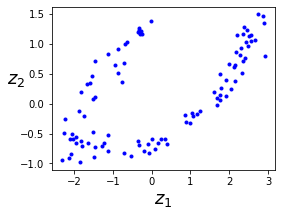

In [18]:
#과소완전 선형 오토인코더에 의해 수행된 PCA

fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.show()

![pca](images/pca.png)

## 적층 오토인코더

여러 개의 은닉층을 가지는 오토인코더이다. 층을 더 추가하면 오토인코더가 더 복잡한 코딩을 학습할 수 있다.
![stacked-ae](images/stacked-ae.png)
적층 오토인코더의 구조는 아래의 그림과 같이 가운데 히든레이어(코딩층)을 기준으로 대칭인 구조를 가진다

In [97]:
#MNIST 데이터 로드
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()
train_x = train_x.astype(np.float32).reshape(-1, 28*28) / 255.0
test_x = test_x.astype(np.float32).reshape(-1, 28*28) / 255.0
train_y = train_y.astype(np.int32)
test_y = test_y.astype(np.int32)
valid_x, train_x = train_x[:5000], train_x[5000:]
valid_y, train_y = train_y[:5000], train_y[5000:]

# Mini-batch
def shuffle_batch(features, labels, batch_size):
    rnd_idx = np.random.permutation(len(features))
    n_batches = len(features) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        batch_x, batch_y = features[batch_idx], labels[batch_idx]
        yield batch_x, batch_y

In [20]:
from functools import partial

tf.reset_default_graph()

n_inputs = 28 * 28 #MNIST이미지
n_hidden1 = 300
n_hidden2 = 150 #코딩
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init = tf.variance_scaling_initializer() #he초기화
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg) #l2규제
my_dense_layer = partial(tf.layers.dense,
                        activation=tf.nn.elu,
                        kernel_initializer=he_init,
                        kernel_regularizer=l2_regularizer)

hidden1 = my_dense_layer(X, n_hidden)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs-X))
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

n_epoch = 5
batch_size = 150

save_model = tf.train.Saver()

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(n_epoch):
        n_batches = len(train_x) // batch_size #배치사이즈
        for iteration in range(n_batches):
            X_batch, _ = next(shuffle_batch(train_x, train_y, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
        print(f"epoch :{epoch+1}\tloss : {sess.run(loss, feed_dict={X: valid_x}):.3f}")
    save_model.save(sess, './model/stacked_ae.ckpt') #모델저장

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

epoch :1	loss : 0.059
epoch :2	loss : 0.055
epoch :3	loss : 0.054
epoch :4	loss : 0.054
epoch :5	loss : 0.054


In [3]:
# 오토인코더로 학습시킨 이미지
def show_reconstructed_digits(X, outputs, model_path=None, n_test_digits=2):
    with tf.Session() as sess:
        if model_path:
            save_model.restore(sess, model_path)
        outputs_val = outputs.eval(feed_dict={X: test_x[:n_test_digits]})

    fig = plt.figure(figsize=(10, 4))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(test_x[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])
        
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # 최소값을 0으로 만들어 패딩이 하얗게 보이도록 합니다.
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

INFO:tensorflow:Restoring parameters from ./model/stacked_ae.ckpt


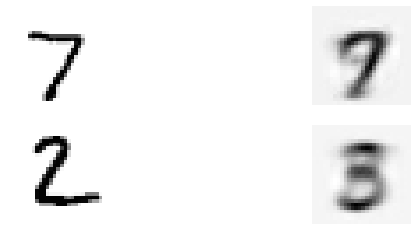

In [22]:
show_reconstructed_digits(X, outputs, './model/stacked_ae.ckpt')

### 이상적인 출력값
![stacked-ae02](images/stacked-ae02.png)

## 가중치 묶기

![stacked-ae03](images/stacked-ae03.png)

오토인코더가 완벽하게 대칭일 경우 일반적으로 <b style="background:#AEA">디코더의 가중치와 인코더의 가중치를 묶는다.</b>
<br>
이 방법은 모델에 있는 <b style="background:#AEA">가중치의 수를 절반</b>으로 줄일 수 있고 <b style="background:#AEA">훈련 속도를 높이고</b> <b style="background:#AEA">과대적합의 위험을 줄여줌</b>.
<br>
텐서플로에서 tf.layers.dense() 함수를 사용해 가중치를 묶으려면 직접 층을 정의해아 함.

In [23]:
tf.reset_default_graph()

n_inputs = 28 * 28 #MNIST이미지
n_hidden1 = 300
n_hidden2 = 150 #코딩
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

activation = tf.nn.elu
he_init = tf.variance_scaling_initializer() #he초기화
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg) #l2규제

#가중치 초기화#
weights1_init = he_init([n_inputs, n_hidden1])
weights2_init = he_init([n_hidden1, n_hidden2])

#가중치 묶기#
weight1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weight2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weight3 = tf.transpose(weight2, name="weights3") #가중치 묶기, weight2의 전치
weight4 = tf.transpose(weight1, name="Weights4") #가중치 묶기, weight1의 전치

#바이어스#
biases1 = tf.Variable(tf.zeros([n_hidden1]), dtype=tf.float32, name="biases1") #편향은 묶지않음, 규제 안함
biases2 = tf.Variable(tf.zeros([n_hidden2]), dtype=tf.float32, name="biases2") #편향은 묶지않음, 규제 안함
biases3 = tf.Variable(tf.zeros([n_hidden3]), dtype=tf.float32, name="biases3") #편향은 묶지않음, 규제 안함
biases4 = tf.Variable(tf.zeros([n_outputs]), dtype=tf.float32, name="biases4") #편향은 묶지않음, 규제 안함

#활성화 함수에 통과#
hidden1 = activation(tf.matmul(X, weight1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weight2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weight3) + biases3)
outputs = tf.matmul(hidden3, weight4) + biases4 #마지막 층은 활성화 함수 통과 안 함

#오차 계산#
reconstruction_loss = tf.reduce_mean(tf.square(outputs-X))
reg_losses = l2_regularizer(weights1_init) + l2_regularizer(weights2_init)
loss = reconstruction_loss + reg_losses

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

n_epoch = 5
batch_size = 150

save_model = tf.train.Saver()

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(n_epoch):
        n_batches = len(train_x) // batch_size #배치사이즈
        for iteration in range(n_batches):
            X_batch, _ = next(shuffle_batch(train_x, train_y, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
        print(f"epoch :{epoch+1}\tloss : {sess.run(loss, feed_dict={X: valid_x}):.3f}")
    save_model.save(sess, './model/stacked_ae_tied.ckpt') #모델저장

epoch :1	loss : 0.053
epoch :2	loss : 0.043
epoch :3	loss : 0.039
epoch :4	loss : 0.035
epoch :5	loss : 0.034


INFO:tensorflow:Restoring parameters from ./model/stacked_ae_tied.ckpt


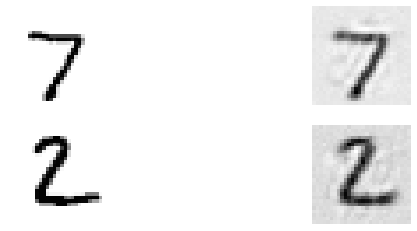

In [24]:
show_reconstructed_digits(X, outputs, './model/stacked_ae_tied.ckpt')

## 한 번에 한 층씩 훈련하기

한 번에 전체 오토인코더를 학습시키는 것보다 <b style="background:#AFA;">한 번에 오토인코더 하나를 학습하고, 이를 쌓아올려서 한 개의 stacked-오토인코더를 만드는 것</b>이 훨씬 빠르며 이러한 방식은 아주 깊은 오토인코더일 경우에 유용하다.

![stacked-ae04](images/stacked-ae04.png)

<ul>
    <li>[단계 1]에서 첫 번째 오토인코더는 입력을 재구성하도록 학습된다.</li>
    <li>[단계 2]에서는 두 번째 오토인코더가 첫 번째 히든 레이어(Hidden 1)의 출력을 재구성하도록 학습된다.</li>
    <li>[단계 3]에서는 단계1 ~ 2의 오토인코더를 합쳐 최종적으로 하나의 stacked-오토인코더를 구현한다.</li>
</ul>

텐서플로에서 이렇게 여러 단계의 오토인코더를 학습시키는 방법으로는 다음과 같이 두 가지 방법이 있다.
<ol>
    <li>각 단계마다 다른 텐서플로 그래프(graph)를 사용하는 방법</li>
    <li>하나의 그래프에 각 단계의 학습을 수행하는 방법</li>
</ol>

## 각 단계마다 다른 텐서플로 그래프(graph)를 사용하는 방법

In [145]:
from functools import partial
import sys

#가중치 묶은 버전#
def train_tied_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                      learning_rate = 0.01, l2_reg = 0.0005, seed=42,
                      hidden_activation=tf.nn.elu,
                      output_activation=tf.nn.elu):
    graph = tf.Graph()
    with graph.as_default():
        n_inputs = n_outputs = X_train.shape[1]
        
        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
        initializer = tf.variance_scaling_initializer()
        
        weight_in_init = initializer([n_inputs, n_neurons])
        
        weight_in = tf.Variable(weight_in_init, dtype=tf.float32)
        weight_out = tf.transpose(weight_in) #가중치 묶기
        
        bias_in = tf.Variable(tf.zeros(n_neurons))
        bias_out = tf.Variable(tf.zeros(n_outputs))
        
        hidden = hidden_activation(tf.matmul(X, weight_in) + bias_in)
        outputs = output_activation(tf.matmul(hidden, weight_out) + bias_out) if output_activation else tf.matmul(hidden, weight_out) + bias_out

        reconstruction_loss = tf.reduce_mean(tf.square(outputs-X))
        reg_loss = regularizer(weight_in)
        loss = reconstruction_loss + reg_loss
        
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        training_op = optimizer.minimize(loss)
        
        with tf.Session(graph=graph, config=config) as sess:
            sess.run(tf.global_variables_initializer())
            n_batches = len(X_train) // batch_size
            for epoch in range(n_epochs):
                for iteration in range(n_batches):
                    print("\r{}%".format(100 * iteration // n_batches), end="")
                    sys.stdout.flush()
                    indices = rnd.permutation(len(X_train))[:batch_size]
                    X_batch = X_train[indices]
                    sess.run(training_op, feed_dict={X: X_batch})
                loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
                print("\r{}".format(epoch), "훈련 MSE:", loss_train)
            
            hidden_val = sess.run(hidden, feed_dict={X:X_train})
            ret_weight_in, ret_weight_out = sess.run([weight_in, weight_out])
            ret_bias_in, ret_bias_out = sess.run([bias_in, bias_out])
            return hidden_val, ret_weight_in, ret_bias_in, ret_weight_out, ret_bias_out

In [146]:
## 가중치 묶은 버전 ##

tf.reset_default_graph()

# 첫 번째 층
hidden1_outputs, w1, b1, w6, b6 = train_tied_autoencoder(train_x, n_neurons=576, n_epochs=5,
                                                         batch_size=150, output_activation=None, l2_reg=0.0001)

# 두 번째 층
hidden2_outputs, w2, b2, w5, b5 = train_tied_autoencoder(hidden1_outputs, n_neurons=432, n_epochs=5,
                                                         batch_size=150, l2_reg=0.0001)

# 세 번째 층
_, w3, b3, w4, b4 = train_tied_autoencoder(hidden2_outputs, n_neurons=324, n_epochs=5,
                                           batch_size=150, l2_reg=0.0001)

0 훈련 MSE: 0.0040145493
1 훈련 MSE: 0.00384855
2 훈련 MSE: 0.0043657
3 훈련 MSE: 0.004238016
4 훈련 MSE: 0.004419134
0 %훈련 MSE: 0.0020583672
1 훈련 MSE: 0.0015017611
2 %훈련 MSE: 0.0014082992
3 훈련 MSE: 0.0015075787
4 훈련 MSE: 0.0017370342
0 훈련 MSE: 0.0014677905
1 훈련 MSE: 0.0007843468
2 훈련 MSE: 0.00079095125
3 훈련 MSE: 0.0009811362
4 훈련 MSE: 0.0014394935


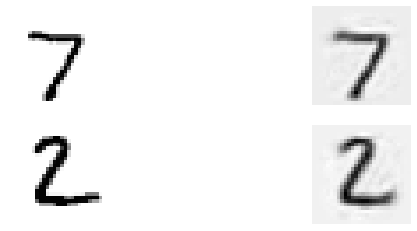

In [147]:
n_inputs = 28*28

tf.global_variables_initializer()
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, w1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, w2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, w3) + b3)
hidden4 = tf.nn.elu(tf.matmul(hidden3, w4) + b4)
hidden5 = tf.nn.elu(tf.matmul(hidden4, w5) + b5)
outputs = tf.matmul(hidden5, w6) + b6

show_reconstructed_digits(X, outputs)

In [142]:
from functools import partial
import sys

#가중치 안 묶은 버전#
def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                      learning_rate = 0.01, l2_reg = 0.0005, seed=42,
                      hidden_activation=tf.nn.elu,
                      output_activation=tf.nn.elu):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)

        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=tf.variance_scaling_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))

        hidden = my_dense_layer(X, n_neurons, activation=hidden_activation, name="hidden")
        outputs = my_dense_layer(hidden, n_inputs, activation=output_activation, name="outputs")

        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()
    
    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X: X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "훈련 MSE:", loss_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

In [143]:
## 가중치 안 묶은 버전 ##

tf.reset_default_graph()

# 첫 번째 층
hidden1_outputs, w1, b1, w4, b4 = train_autoencoder(train_x, n_neurons=300, n_epochs=5, batch_size=150,output_activation=None)

# 두 번째 층
_, w2, b2, w3, b3 = train_autoencoder(hidden1_outputs, n_neurons=150, n_epochs=5, batch_size=150)

0 훈련 MSE: 0.01906789
1 훈련 MSE: 0.019290097
2 훈련 MSE: 0.018617999
3 훈련 MSE: 0.017881682
4 훈련 MSE: 0.019459112
0 훈련 MSE: 0.0045077954
1 훈련 MSE: 0.0044194534
2 훈련 MSE: 0.004559014
3 훈련 MSE: 0.004418278
4 훈련 MSE: 0.0046330476


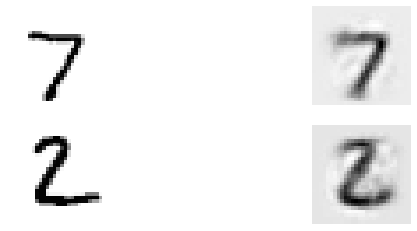

In [144]:
n_inputs = 28*28

tf.global_variables_initializer()
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, w1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, w2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, w3) + b3)
outputs = tf.matmul(hidden3, w4) + b4

show_reconstructed_digits(X, outputs)

## 하나의 그래프에서 오토인코더를 각가 학습하기

전체 적층 오토인코더를 위한 그래프를 만들지만 각 오토인코더를 독립적으로 학습하기 위한 연산도 추가합니다. 단계 1은 맨 아래층과 맨 윗층을 훈련하고(즉, 첫 번째 오토인코더), 단계 2는 두 개의 가운데 층을 훈련한다(즉, 두 번째 오토인코더).

![stacked-ae05](images/stacked-ae05.png)

In [29]:
import sys

tf.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # 코딩 유닛
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.variance_scaling_initializer()

W1_init = initializer([n_inputs, n_hidden1])
W2_init = initializer([n_hidden1, n_hidden2])
W3_init = initializer([n_hidden2, n_hidden3])
W4_init = initializer([n_hidden3, n_outputs])

W1 = tf.Variable(W1_init, dtype=tf.float32, name="weights1")
W2 = tf.Variable(W2_init, dtype=tf.float32, name="weights2")
W3 = tf.Variable(W3_init, dtype=tf.float32, name="weights3")
W4 = tf.Variable(W4_init, dtype=tf.float32, name="weights4")

b1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
b2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
b3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
b4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

inputs = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = activation(tf.matmul(inputs, W1) + b1)
hidden2 = activation(tf.matmul(hidden1, W2) + b2)
hidden3 = activation(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

reconstruction_loss = tf.losses.mean_squared_error(labels=inputs, predictions=outputs)

optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, W4) + b4  # hidden2와 hidden3 제외
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - inputs))
    phase1_reg_loss = regularizer(W1) + regularizer(W4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(W2) + regularizer(W3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [W2, b2, W3, b3] #학습될 텐서 지정
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars) # hidden1 동결
    

save_model = tf.train.Saver()

training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    for phase in range(2):
        print("훈련 단계 #{}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            n_batches = len(train_x) // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                batch_x, batch_y = next(shuffle_batch(train_x, train_y, batch_sizes[phase]))
                sess.run(training_ops[phase], feed_dict={inputs: batch_x})
            loss_train = reconstruction_losses[phase].eval(feed_dict={inputs: batch_x})
            print("\r{}".format(epoch), "훈련 MSE:", loss_train)
    loss_test = reconstruction_loss.eval(feed_dict={inputs: test_x})
    print("테스트 MSE:", loss_test)
    save_model.save(sess, "./model/my_model_one_at_a_time.ckpt")

훈련 단계 #1
0 훈련 MSE: 0.007724679
1 훈련 MSE: 0.007237235
2 훈련 MSE: 0.0082519045
3 %훈련 MSE: 0.008145345
훈련 단계 #2
0 훈련 MSE: 0.07386519
1 훈련 MSE: 0.0040200143
2 훈련 MSE: 0.0025891021
3 훈련 MSE: 0.002077696
테스트 MSE: 0.009810922


INFO:tensorflow:Restoring parameters from ./model/my_model_one_at_a_time.ckpt


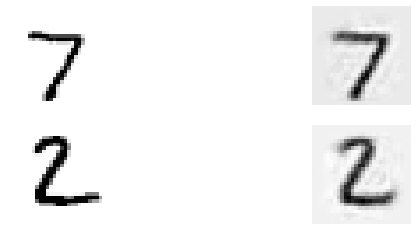

In [30]:
show_reconstructed_digits(inputs, outputs, './model/my_model_one_at_a_time.ckpt')

## 특성 시각화

랜덤한 입력 이미지를 오토인코더에 주입하고, 관심 있는 뉴런의 활성화를 관찰해서 이 뉴런이 더 활성화되는 방향으로 이미지를 수정하도록 역전파를 수행할 수 있다. 이를 여러 번 반복하면<b style="background:#AFA;">(경사 상승법을 수행하며)</b> 이미지는 점차 그 뉴런을 위한 좋은 방향으로 변화함

INFO:tensorflow:Restoring parameters from ./model/my_model_one_at_a_time.ckpt


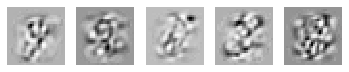

In [31]:
with tf.Session() as sess:
    save_model.restore(sess, "./model/my_model_one_at_a_time.ckpt")
    W1_val = W1.eval()

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plot_image(W1_val.T[i])

plt.show()

## 적층(stacked) 오토인코더를 사용한 비지도 사전훈련

레이블되어 있는 훈련 데이터가 많지 않은 복잡한 지도 학습 문제를 다루어야한다면 <b style="background:#AFA;">비슷한 문제에 학습된 신경망을 찾아 하위층을 재사용</b>하는 것은 좋은 생각이다. 적층 오토인코더 자체는 한 번에 한 층씩 훈련된다. 분류기를 훈련할 때 레이블된 룬현 데이터가 많지 않으면 사전훈련된 층을 동결하는 것이 좋다.

![unsupervised](images/unsupervised.png)

## 잡음제거(denoising) 오토인코더

오토인코더가 유용한 특성을 학습하도록 강제하도록 입력에 잡을을 추가하고, 노이즈가 없는 원본 입력을 복원하도록 훈련한다.
노이즈는 입력에 가우시안(Gaussian) 노이즈를 추가하거나, 드롭아웃(dropout)처럼 랜덤하게 입력 유닛(노드)를 꺼서 발생 시킬 수 있다.

![denoising](images/denoising.png)

In [153]:
## 가우시안 노이즈 추가

tf.reset_default_graph()

noise_level = 1.0
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # coding units
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
n_epochs = 10
batch_size = 150

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

hidden1 = tf.layers.dense(X_noisy, n_hidden1, activation=tf.nn.elu, name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name='hidden2')
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name='hidden3')
outputs = tf.layers.dense(hidden3, n_outputs, name='outputs')

# loss 
reconstruction_loss = tf.losses.mean_squared_error(labels=X, predictions=outputs)
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

save_model = tf.train.Saver()

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    n_batches = len(train_x) // batch_size
    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            batch_x, batch_y = next(shuffle_batch(train_x, train_y, batch_size))
            sess.run(training_op, feed_dict={X: batch_x})
        loss_train = reconstruction_loss.eval(feed_dict={X: batch_x})
        print('\repoch : {}, Train MSE : {:.5f}'.format(epoch, loss_train))
    save_model.save(sess, './model/my_model_stacked_denoising_gaussian.ckpt')

epoch : 0, Train MSE : 0.04173
epoch : 1, Train MSE : 0.04349
epoch : 2, Train MSE : 0.04255
epoch : 3, Train MSE : 0.04162
epoch : 4, Train MSE : 0.04428
epoch : 5, Train MSE : 0.04509
epoch : 6, Train MSE : 0.04196
epoch : 7, Train MSE : 0.04326
epoch : 8, Train MSE : 0.04359
epoch : 9, Train MSE : 0.04467


INFO:tensorflow:Restoring parameters from ./model/my_model_stacked_denoising_gaussian.ckpt


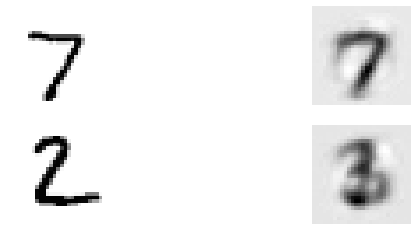

In [155]:
show_reconstructed_digits(X, outputs, './model/my_model_stacked_denoising_gaussian.ckpt')

In [156]:
## 드롭아웃 사용

tf.reset_default_graph()

## 가우시안 노이즈 추가

tf.reset_default_graph()

dropout_rate = 0.3
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # coding units
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
n_epochs = 10
batch_size = 150

training = tf.placeholder_with_default(False, shape=(), name="training")
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_dropout = tf.layers.dropout(X, dropout_rate, training=training)

hidden1 = tf.layers.dense(X_dropout, n_hidden1, activation=tf.nn.elu, name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name='hidden2')
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name='hidden3')
outputs = tf.layers.dense(hidden3, n_outputs, name='outputs')

# loss 
reconstruction_loss = tf.losses.mean_squared_error(labels=X, predictions=outputs)
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

save_model = tf.train.Saver()

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    n_batches = len(train_x) // batch_size
    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            batch_x, batch_y = next(shuffle_batch(train_x, train_y, batch_size))
            sess.run(training_op, feed_dict={X: batch_x, training:True})
        loss_train = reconstruction_loss.eval(feed_dict={X: batch_x})
        print('\repoch : {}, Train MSE : {:.5f}'.format(epoch, loss_train))
    save_model.save(sess, './model/my_model_stacked_denoising_dropout.ckpt')

Instructions for updating:
Use keras.layers.dropout instead.
epoch : 0, Train MSE : 0.04138
epoch : 1, Train MSE : 0.03657
epoch : 2, Train MSE : 0.03256
epoch : 3, Train MSE : 0.03230
epoch : 4, Train MSE : 0.03154
epoch : 5, Train MSE : 0.03352
epoch : 6, Train MSE : 0.03101
epoch : 7, Train MSE : 0.02974
epoch : 8, Train MSE : 0.03164
epoch : 9, Train MSE : 0.03097


INFO:tensorflow:Restoring parameters from ./model/my_model_stacked_denoising_dropout.ckpt


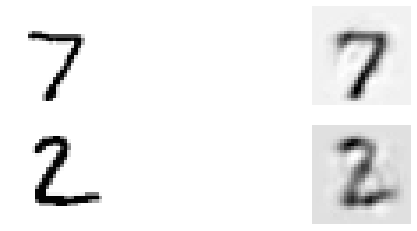

In [160]:
show_reconstructed_digits(X, outputs, './model/my_model_stacked_denoising_dropout.ckpt')

## 희소 오토인코더

오토인코더가 좋은 특성을 추출하도록 만드는 다른 제약 방법은 희소성(sparsity)를 이용하는 것인데, 이러한 오토인코더를 Sparse Autoencoder라고 한다. 이 방법은 손실함수에 적절한 항을 추가하여 오토인코더가 코딩층(coding layer, 가운데 층)에서 활성화되는 뉴런 수를 감소시키는 것이다. 예를들어 코딩층에서 평균적으로 5% 뉴런만 활성화되도록 만들어 주게 되면, 오토인코더는 5%의 뉴런을 조합하여 입력을 재구성해야하기 때문에 유용한 특성을 표현하게 된다.

이러한 Sparse-오토인코더를 만들기 위해서는 먼저 학습 단계에서 코딩층의 실제 sparse(희소) 정도를 측정해야 하는데, 전체 학습 배치(batch)에 대해 코딩층의 평균적인 활성화를 계산한다. 배치의 크기는 너무 작지 않게 설정 해준다.

각 뉴런에 대한 평균 활성화 정도를 계산하여 구하고, 손실함수에 희소 손실(sparsity loss)를 추가하여 뉴런이 크게 활성화 되지 않도록 규제할 수 있다. 예를들어 한 뉴런의 평균 활성화가 0.3이고 목표 희소 정도가 0.1이라면, 이 뉴런은 덜 활성화 되도록 해야한다. 희소 손실을 구하는 간단한 방법으로는 제곱 오차 $(0.3 - 0.1)^{2}$를 추가하는 방법이 있다. 하지만, Sparse-오토인코더에서는 아래의 그래프 처럼 MSE보다 더 경사가 급한 쿨백 라이블러 발산(KL-divergense, Kullback-Leibler divergense)을 사용한다.

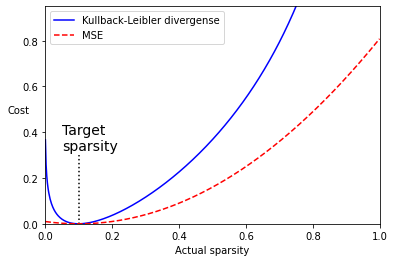

In [164]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="Kullback-Leibler divergense")
plt.plot(q, mse, "r--", label="MSE")
plt.legend(loc="upper left")
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95]);

### 쿨백 라이블러 발산

쿨백-라이블러 발산(Kullback-Leibler divergence, KLD)은 <b style="background:#AFA;">두 확률분포의 차이를 계산</b>하는 데 사용하는 함수이다. 예를들어 딥러닝 모델을 만들 때, 학습 데이터셋의 분포 $P(x)$와 모델이 추정한 데이터의 분포 $Q(x)$ 간에 차이를 KLD를 활용해 구할 수 있다(ratsgo's blog).

$$
{ D }_{ KL }\left( P||Q \right) ={ E }_{ X\sim P }\left[ \log { \frac { P\left( x \right)  }{ Q(x) }  }  \right] ={ E }_{ X\sim P }\left[ \log { P(x) } -\log { Q(x) }  \right]
$$
Sparse-오토인코더에서는 코딩층에서 뉴런이 활성화될 목표 확률 $p$와 실제확률 $q$(학습 배치에 대한 평균 활성화) 사이의 발산을 측정하며, 식은 다음과 같다.

$$
D_{KL}\left( p||q \right) = p \log{\frac{p}{q}} + \left( 1- p \right) \log{\frac{1-p}{1-q}}
$$
위의 식을 이용해 코딩층의 각 뉴런에 대해 희소 손실을 구하고 이 손실을 모두 합한 뒤 희소 가중치 하이퍼파라미터를 곱하여 손실함수의 결과에 더해준다.$$
Loss = \text{MSE} + \text{sparsity_weight} \times \text{sparsity_loss}
$$



In [166]:
def kl_divergence(p, q): #쿨백 라이블러 발산
    return p * tf.log(p / q) + (1-p) * tf.log((1-p) / (1-q))

In [174]:
tf.reset_default_graph()

noise_level = 1.0
n_inputs = 28 * 28
n_hidden1 = 1000 # sparsity coding units
n_outputs = n_inputs

sparsity_target = 0.1  # p
sparsity_weight = 0.2
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid) # 코딩층의 활성화가 반드시 0 ~ 1 이여야 함
outputs = tf.layers.dense(hidden1, n_outputs)

hidden1_mean = tf.reduce_mean(hidden1, axis=0) # 배치 평균
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE
loss = reconstruction_loss + sparsity_weight * sparsity_loss #뉴런의 활성을 억제

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

save_model = tf.train.Saver()

n_epochs = 50
batch_size = 1000

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    n_batches = len(train_x) // batch_size
    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = next(shuffle_batch(train_x, train_y, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "훈련 MSE:", reconstruction_loss_val, "\t희소 손실:", sparsity_loss_val, "\t전체 손실:", loss_val)
        save_model.save(sess, "./my_model_sparse.ckpt")

0 훈련 MSE: 0.11550293 	희소 손실: 0.17020297 	전체 손실: 0.14954352
1 훈련 MSE: 0.060130365 	희소 손실: 0.43359601 	전체 손실: 0.14684957
2 훈련 MSE: 0.052617073 	희소 손실: 0.017094705 	전체 손실: 0.056036014
3 훈련 MSE: 0.049924262 	희소 손실: 0.18441711 	전체 손실: 0.08680768
4 훈련 MSE: 0.047064483 	희소 손실: 0.5488177 	전체 손실: 0.15682802
5 훈련 MSE: 0.04323981 	희소 손실: 0.03149784 	전체 손실: 0.049539376
6 훈련 MSE: 0.038364638 	희소 손실: 0.0071519003 	전체 손실: 0.03979502
7 훈련 MSE: 0.035511713 	희소 손실: 0.032681514 	전체 손실: 0.042048015
8 훈련 MSE: 0.032990478 	희소 손실: 0.09216493 	전체 손실: 0.051423468
9 훈련 MSE: 0.030195517 	희소 손실: 0.03373652 	전체 손실: 0.03694282
10 훈련 MSE: 0.027508296 	희소 손실: 0.123387374 	전체 손실: 0.052185774
11 훈련 MSE: 0.025257325 	희소 손실: 0.02386567 	전체 손실: 0.03003046
12 훈련 MSE: 0.024105703 	희소 손실: 0.036841363 	전체 손실: 0.031473976
13 훈련 MSE: 0.023014802 	희소 손실: 0.12471248 	전체 손실: 0.0479573
14 훈련 MSE: 0.023470763 	희소 손실: 0.55624616 	전체 손실: 0.13472
15 훈련 MSE: 0.020145876 	희소 손실: 0.028324716 	전체 손실: 0.02581082
16 훈련 MSE: 0.02075354 	희소 손실

INFO:tensorflow:Restoring parameters from ./my_model_sparse.ckpt


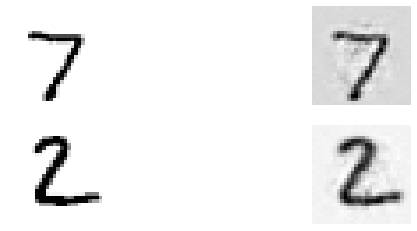

In [175]:
show_reconstructed_digits(X, outputs, "./my_model_sparse.ckpt")

In [183]:
tf.reset_default_graph()

noise_level = 1.0
n_inputs = 28 * 28
n_hidden1 = 1000 # sparsity coding units
n_outputs = n_inputs

sparsity_target = 0.1  # p
sparsity_weight = 0.2
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

### 훈련 속도를 높이기 위해 입력을 0과 1사이로 정규화, 비용함수를 MSE 대신 크로스엔트로피 사용 ##
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid) # 코딩층의 표현은 반드시 0 ~ 1 이여야 함
logits = tf.layers.dense(hidden1, n_outputs)
outputs = tf.nn.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_mean(xentropy)
################################

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

save_model = tf.train.Saver()

n_epochs = 25
batch_size = 1000

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    n_batches = len(train_x) // batch_size
    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = next(shuffle_batch(train_x, train_y, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val = sess.run(reconstruction_loss, feed_dict={X: X_batch})
        print("\r{}".format(epoch),"\t전체 손실:", loss_val)
        save_model.save(sess, "./my_model_sparse_crossentropy.ckpt")

0 	전체 손실: 0.17506434
1 	전체 손실: 0.11967491
2 	전체 손실: 0.09570947
3 	전체 손실: 0.08378771
4 	전체 손실: 0.077956766
5 	전체 손실: 0.07496484
6 	전체 손실: 0.07216516
7 	전체 손실: 0.07072189
8 	전체 손실: 0.070643306
9 	전체 손실: 0.06968847
10 	전체 손실: 0.06875735
11 	전체 손실: 0.06734003
12 	전체 손실: 0.06757271
13 	전체 손실: 0.06761032
14 	전체 손실: 0.06560719
15 	전체 손실: 0.06667484
16 	전체 손실: 0.06623076
17 	전체 손실: 0.06534455
18 	전체 손실: 0.06626058
19 	전체 손실: 0.06575818
20 	전체 손실: 0.06617916
21 	전체 손실: 0.06419484
22 	전체 손실: 0.0655994
23 	전체 손실: 0.06578811
24 	전체 손실: 0.06505808


INFO:tensorflow:Restoring parameters from ./my_model_sparse_crossentropy.ckpt


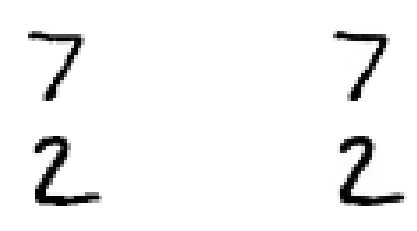

In [184]:
show_reconstructed_digits(X, outputs, "./my_model_sparse_crossentropy.ckpt")

## 변이형 오토인코더(Variational AutoEncoder)

변이형 오토인코더의 특징

<ol>
    <li>확률적 오토인코더 : 학습이 끝난 후에도 출력이 부분적으로 우연에 의해 결정됨</li>
    <li>생성 오토인코더 : 훈련 세트에서 샘플링된 것 같은 새로운 샘플을 생성</li>
</ol>

![vae](images/vae.png)

VAE의 코딩층은 다른 오토인코더와는 다른 부분이 있는데 주어진 입력에 대해 바로 코딩을 만드는 것이 아니라, 인코더(encoder)는 평균 코딩 $\mu$와 표준편차 코딩 $\sigma$ 을 만든다. 실제 코딩은 평균이 $\mu$이고 표준편차가 $\sigma$인 가우시안 분포(gaussian distribution)에서 랜덤하게 샘플링되며, 이렇게 샘플링된 코딩을 디코더(decoder)가 원본 입력으로 재구성하게 된다.

VAE는 마치 가우시안 분포에서 샘플링된 것처럼 보이는 코딩을 만드는 경향이 있는데, 학습하는 동안 손실함수가 코딩(coding)을 가우시안 샘플들의 집합처럼 보이는 형태를 가진 코딩 공간(coding space) 또는 잠재 변수 공간(latent space)로 이동시키기 때문이다.

이러한 이유로 VAE는 학습이 끝난 후에 새로운 샘플을 가우시안 분포로 부터 랜덤한 코딩을 샘플링해 디코딩해서 생성할 수 있다.

### 변이형 오토인코더의 비용함수

변이형 오토인코더의 비용함수의 두 가지 부분

![vae_loss](images/vae_loss.png)

<ol>
    <li>오토인코더가 입력을 재생산하도록 만드는 일반적인 재구성 손실</li>
    <li>간단한 가우시안 분포에서 샘플된 것 같은 코딩을 가지도록 오토인코더를 강제하는 <b>잠재 변수 손실(latent loss)</b></li>
    <b style="background:#AFA;font-size:1.2em">자주 사용하는 변형은 인코더가 $\sigma$ 대신 $\gamma = log(\sigma)^2$를 출력하도록 훈련시키는 것</b>
    <br>
    <b style="background:#AFA;font-size:1.2em">$\sigma$는 $\sigma$ = exp( $\gamma \over 2$ )로 쉽게 계산 가능하기 때문이다.</b>
</ol>

### 인코더가 $\sigma$ 출력하도록 함

In [211]:
tf.reset_default_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # 코딩 유닛
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.variance_scaling_initializer()

my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)
hidden3 = hidden3_mean + hidden3_sigma * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)

eps = 1e-10 # NaN을 반환하는 log(0)을 피하기 위한 안전항

## 인코더가 시그마를 출력하게 함 ##
latent_loss = 0.5 * tf.reduce_sum(
    tf.square(hidden3_sigma) + tf.square(hidden3_mean)
    - 1 - tf.log(eps + tf.square(hidden3_sigma)))
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
save_model = tf.train.Saver()

n_epochs = 25
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(train_x) // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = next(shuffle_batch(train_x, train_y, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "훈련 전체 손실:", loss_val, "\t재구성 손실:", reconstruction_loss_val, "\t잠재 손실:", latent_loss_val)
        save_model.save(sess, "./my_model_variational.ckpt")

0 훈련 전체 손실: 36532.39 	재구성 손실: 26799.781 	잠재 손실: 9732.611
1 훈련 전체 손실: 28542.613 	재구성 손실: 23352.414 	잠재 손실: 5190.198
2 훈련 전체 손실: 25870.748 	재구성 손실: 20706.83 	잠재 손실: 5163.9175
3 훈련 전체 손실: 26917.406 	재구성 손실: 20872.48 	잠재 손실: 6044.927
4 훈련 전체 손실: 28866.285 	재구성 손실: 21444.809 	잠재 손실: 7421.4766
5 훈련 전체 손실: 22762.3 	재구성 손실: 18747.902 	잠재 손실: 4014.3984
6 훈련 전체 손실: 25264.63 	재구성 손실: 17457.602 	잠재 손실: 7807.0293
7 훈련 전체 손실: 24868.217 	재구성 손실: 19805.701 	잠재 손실: 5062.515
8 훈련 전체 손실: 20013.074 	재구성 손실: 16561.719 	잠재 손실: 3451.3552
9 훈련 전체 손실: 18232.904 	재구성 손실: 15213.623 	잠재 손실: 3019.281
10 훈련 전체 손실: 18842.219 	재구성 손실: 15277.384 	잠재 손실: 3564.8345
11 훈련 전체 손실: 16777.701 	재구성 손실: 13786.045 	잠재 손실: 2991.6567
12 훈련 전체 손실: 16551.713 	재구성 손실: 13353.643 	잠재 손실: 3198.0703
13 훈련 전체 손실: 16420.754 	재구성 손실: 13327.929 	잠재 손실: 3092.8247
14 훈련 전체 손실: 16172.204 	재구성 손실: 12863.626 	잠재 손실: 3308.5781
15 훈련 전체 손실: 15847.65 	재구성 손실: 12610.598 	잠재 손실: 3237.0532
16 훈련 전체 손실: 16538.25 	재구성 손실: 13303.412 	잠재 손실: 3234.8384
17 

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


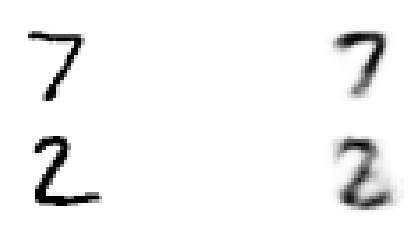

In [190]:
show_reconstructed_digits(X, outputs, "./my_model_variational.ckpt")

### 인코더가 $\gamma = log(\sigma)^2$를 출력하도록 함

In [215]:
tf.reset_default_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # 코딩 유닛
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.variance_scaling_initializer()
my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_gamma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)
hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)
## 인코더가 log(시그마^2)를 출력하도록 함, 더 간단함 ##
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
save_model = tf.train.Saver()

n_epochs = 25
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(train_x) // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = next(shuffle_batch(train_x, train_y, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "훈련 전체 손실:", loss_val, "\t재구성 손실:", reconstruction_loss_val, "\t잠재 손실:", latent_loss_val)
        save_model.save(sess, "./my_model_variational_simple.ckpt")

0 훈련 전체 손실: 18118.25 	재구성 손실: 14426.1875 	잠재 손실: 3692.0615
1 훈련 전체 손실: 16313.805 	재구성 손실: 12638.117 	잠재 손실: 3675.6875
2 훈련 전체 손실: 16469.965 	재구성 손실: 12786.399 	잠재 손실: 3683.5664
3 훈련 전체 손실: 15612.978 	재구성 손실: 11872.88 	잠재 손실: 3740.0974
4 훈련 전체 손실: 15467.398 	재구성 손실: 11698.818 	잠재 손실: 3768.5803
5 훈련 전체 손실: 16411.186 	재구성 손실: 12592.072 	잠재 손실: 3819.1138
6 훈련 전체 손실: 16039.287 	재구성 손실: 12200.082 	잠재 손실: 3839.2048
7 훈련 전체 손실: 15809.843 	재구성 손실: 12050.366 	잠재 손실: 3759.4766
8 훈련 전체 손실: 15756.069 	재구성 손실: 11859.123 	잠재 손실: 3896.9463
9 훈련 전체 손실: 15592.141 	재구성 손실: 11778.2295 	잠재 손실: 3813.9114
10 훈련 전체 손실: 15292.208 	재구성 손실: 11551.424 	잠재 손실: 3740.7844
11 훈련 전체 손실: 15231.672 	재구성 손실: 11452.541 	잠재 손실: 3779.1313
12 훈련 전체 손실: 15420.098 	재구성 손실: 11648.584 	잠재 손실: 3771.5137
13 훈련 전체 손실: 15312.479 	재구성 손실: 11480.569 	잠재 손실: 3831.9094
14 훈련 전체 손실: 14692.844 	재구성 손실: 11031.753 	잠재 손실: 3661.0908
15 훈련 전체 손실: 15147.089 	재구성 손실: 11437.846 	잠재 손실: 3709.2434
16 훈련 전체 손실: 15112.918 	재구성 손실: 11457.706 	잠재 손실: 

INFO:tensorflow:Restoring parameters from ./my_model_variational_simple.ckpt


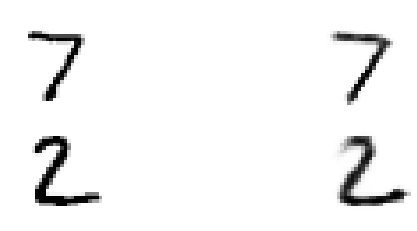

In [193]:
show_reconstructed_digits(X, outputs, "./my_model_variational_simple.ckpt")

## 숫자이미지 생성

위의 변이형 오토인코더를 훈련시켜 랜덤한 이미지를 생성해 보겠습니다:D

In [212]:
import numpy as np

n_digits = 60
n_epochs = 25
batch_size = 150

save_model = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    save_model.restore(sess, "./my_model_variational.ckpt")
    for epoch in range(n_epochs):
        n_batches = len(train_x) // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()                                          # not shown
            X_batch, y_batch = next(shuffle_batch(train_x, train_y, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) # not shown
        print("\r{}".format(epoch), "훈련 전체 손실:", loss_val, "\t재구성 손실:", reconstruction_loss_val, "\t잠재 손실:", latent_loss_val)  # not shown
    
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt
0 훈련 전체 손실: 23164.227 	재구성 손실: 18820.645 	잠재 손실: 4343.583
1 훈련 전체 손실: 26652.568 	재구성 손실: 18711.777 	잠재 손실: 7940.7905
2 훈련 전체 손실: 25596.63 	재구성 손실: 20139.777 	잠재 손실: 5456.853
3 훈련 전체 손실: 30848.75 	재구성 손실: 21959.799 	잠재 손실: 8888.95
4 훈련 전체 손실: 25120.604 	재구성 손실: 19364.45 	잠재 손실: 5756.154
5 훈련 전체 손실: 22280.941 	재구성 손실: 18530.648 	잠재 손실: 3750.2937
6 훈련 전체 손실: 19837.207 	재구성 손실: 16419.73 	잠재 손실: 3417.4773
7 훈련 전체 손실: 20401.623 	재구성 손실: 16936.262 	잠재 손실: 3465.3618
8 훈련 전체 손실: 19247.139 	재구성 손실: 15585.359 	잠재 손실: 3661.7788
9 훈련 전체 손실: 17662.012 	재구성 손실: 14470.744 	잠재 손실: 3191.2676
10 훈련 전체 손실: 18370.38 	재구성 손실: 14841.031 	잠재 손실: 3529.3494
11 훈련 전체 손실: 17137.678 	재구성 손실: 13892.617 	잠재 손실: 3245.061
12 훈련 전체 손실: 16322.489 	재구성 손실: 13004.516 	잠재 손실: 3317.9734
13 훈련 전체 손실: 15527.451 	재구성 손실: 12350.321 	잠재 손실: 3177.1296
14 훈련 전체 손실: 16105.9 	재구성 손실: 12807.801 	잠재 손실: 3298.0994
15 훈련 전체 손실: 14959.322 	재구성 손실: 11735.514 	잠재 손실: 322

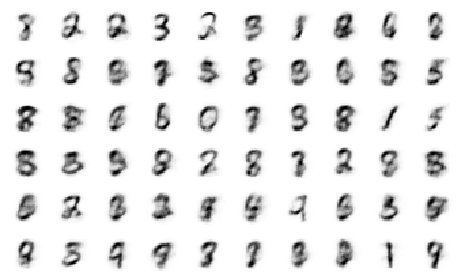

In [213]:
#생성된 이미지
plt.figure(figsize=(8,50)) # 책에는 없음

for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])

In [216]:
import numpy as np

## 잠재손실함수 간소화 버전 ##

n_digits = 60
n_epochs = 25
batch_size = 150

save_model = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    save_model.restore(sess, "./my_model_variational_simple.ckpt")
    for epoch in range(n_epochs):
        n_batches = len(train_x) // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()                                          # not shown
            X_batch, y_batch = next(shuffle_batch(train_x, train_y, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) # not shown
        print("\r{}".format(epoch), "훈련 전체 손실:", loss_val, "\t재구성 손실:", reconstruction_loss_val, "\t잠재 손실:", latent_loss_val)  # not shown
    
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

INFO:tensorflow:Restoring parameters from ./my_model_variational_simple.ckpt
0 훈련 전체 손실: 15214.125 	재구성 손실: 11402.425 	잠재 손실: 3811.7
1 훈련 전체 손실: 15269.041 	재구성 손실: 11550.205 	잠재 손실: 3718.836
2 훈련 전체 손실: 14861.053 	재구성 손실: 11218.875 	잠재 손실: 3642.1777
3 훈련 전체 손실: 15140.234 	재구성 손실: 11410.877 	잠재 손실: 3729.3577
4 훈련 전체 손실: 14704.644 	재구성 손실: 11024.699 	잠재 손실: 3679.9446
5 훈련 전체 손실: 15094.977 	재구성 손실: 11342.748 	잠재 손실: 3752.229
6 훈련 전체 손실: 15069.522 	재구성 손실: 11299.963 	잠재 손실: 3769.5598
7 훈련 전체 손실: 15187.446 	재구성 손실: 11483.979 	잠재 손실: 3703.4678
8 훈련 전체 손실: 15064.451 	재구성 손실: 11296.734 	잠재 손실: 3767.717
9 훈련 전체 손실: 14052.042 	재구성 손실: 10510.681 	잠재 손실: 3541.3613
10 훈련 전체 손실: 14869.812 	재구성 손실: 11216.928 	잠재 손실: 3652.8838
11 훈련 전체 손실: 14667.682 	재구성 손실: 11065.771 	잠재 손실: 3601.9106
12 훈련 전체 손실: 14785.186 	재구성 손실: 11125.756 	잠재 손실: 3659.4302
13 훈련 전체 손실: 14799.955 	재구성 손실: 11125.484 	잠재 손실: 3674.4705
14 훈련 전체 손실: 15045.808 	재구성 손실: 11282.797 	잠재 손실: 3763.0107
15 훈련 전체 손실: 14918.729 	재구성 손실: 11142.9

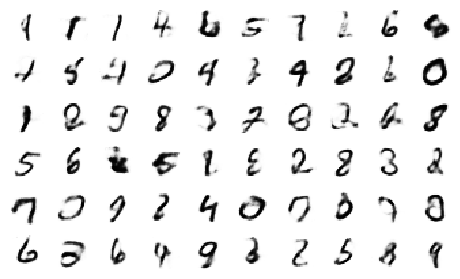

In [217]:
#생성된 이미지
plt.figure(figsize=(8,50)) # 책에는 없음

for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])